<a href="https://colab.research.google.com/github/JeremySpradlin/DS17-Unit-2-Build-Project/blob/master/notebooks/Jeremy_Spradlin_DS17_Unit_2_Build_Seek_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Sun Spots from Upper Atmosphere Fluctuations

We will be creating a dataset that contains radio telescope readings from our upper atmosphere with a dataset that contains the daily number of sunspots in order to predict the number of sunspots based on the upper atmosphereic radio fluctuations.

#Imports


In [1]:
#Installs
%%capture
import sys

!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

In [2]:
#Imports
%matplotlib inline

import pandas_profiling

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import eli5
import shap

from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from pdpbox.pdp import pdp_isolate, pdp_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow back

#Importing our Datasets

In [3]:
#Sun Spot Data
url1 = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/sunspot_data.csv'

#Radio Flux
url2 = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/radio_flux.csv'

sspot = pd.read_csv(url1)
flux = pd.read_csv(url2)

# Wrangle Funcntions

In [4]:
#Sunspot Wrangle Function

def wrangle_sspots(df):
  """This function will take in a dataframe of Sunspot activity
  and perform different functions and actions on it to 
  prepare the dataset for training in a predictive model."""

  #Remove spaces from column names and change to lowercase
  df.columns = df.columns.str.lower().str.replace(' ', '_')

  #Replace -1's in target column
  df['number_of_sunspots'].replace(-1, np.NaN, inplace=True)

  #Remove observations with missing values or no observations
  df = df.dropna()
  mask = df[(df['observations'] == 0)].index
  df = df.drop(mask)

  #Create our datetime column
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    #Remove columns
  df = df.drop(['indicator', 'unnamed:_0', 'year', 'month', 'day', 'date_in_fraction_of_year'], axis=1)

  #move the date column to the front
  col = df.pop('date')
  df.insert(0, 'date', col)

  #Reset Index
  df.reset_index(drop=True, inplace=True)

  return df

In [5]:
#Create our Wrangle function for our radio flux

def wrangle_flux(df):
  """ This function will take in the radio flux dataset and clean
  and adjust the data as needed for joining with the other datasets"""

  #Clean column names
  df = df.rename(columns={
    'year m': 'year',
    'onth': 'month',
  })

  #Create our date column
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

  #Drop extra columns
  df = df.drop(['year', 'month', 'day', 'cont_day'], axis=1)

  #move our date column to the front
  col = df.pop('date')
  df.insert(0, 'date', col)

  #Reset Index
  df.reset_index(drop=True, inplace=True)

  return df


#Cleaning and Joining our datasets

In [6]:
#Clean our datasets
sspot = wrangle_sspots(sspot)
flux = wrangle_flux(flux)

In [7]:
#Join our datasets into one on the date column so that our sunspot tallies align with our radio fluctuations
df = pd.merge(sspot, flux, how='inner', on='date')

df.head()

date  number_of_sunspots  standard_deviation  ...  f3.2_c  f3.2_p  f3.2_f
0 1951-11-01                64.0                 5.3  ...   288.9     3.5       2
1 1951-11-02                81.0                 6.0  ...   287.1     3.5       2
2 1951-11-03                65.0                 5.4  ...   287.0     3.5       2
3 1951-11-04                75.0                 5.8  ...   286.8     3.5       2
4 1951-11-05                86.0                 6.2  ...   288.1     3.5       2

[5 rows x 24 columns]

Train-Val-Test Split

In [8]:
#Create our train/test split function

def split(df):
  """This function will take in our dataset, strip off the time/date stamp,
  and split our dataset into different sets, stratifying on the number of sunspots"""

  #Drop our datetime column so we can use linear regression
  df = df.drop('date', axis=1)

  #Split our datasets into Training and testing sets
  train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

  #Now split our training set into Training and Validation sets
  train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=42)

  return train, val, test


In [9]:
train, val, test = split(df)
train.shape, val.shape, test.shape

((15895, 23), (3974, 23), (4968, 23))

In [10]:
#Split our data into X and y sets
target = 'number_of_sunspots'

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

In [11]:
#Create our baseline and print out our target mean and MAE
guess = y_train.mean()
errors = guess - y_train
mae = errors.abs().mean()
print('Our target mean is', guess)
print('Our naive baseline MAE is', mae)

Our target mean is 91.72758729160114
Our naive baseline MAE is 67.69161237323478


# Initial LinearRegression Pipeilne -model-

In [12]:
#Create our initial model with Linear Regression

model = make_pipeline(
    StandardScaler(),
    SelectKBest(k='all'),
    LinearRegression()
)

In [13]:
#Fit our data to our model
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
                 SelectKBest(k='all',
                             score_func=<function f_classif at 0x7fab78e7ef28>)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [14]:
#Check our accuracy on our different sets
print('Training Accuracy: ', model.score(X_train, y_train))
print('Validation Accuracy: ', model.score(X_val, y_val))
print('Testing Accuracy: ', model.score(X_test, y_test))

Training Accuracy:  0.9276294474130982
Validation Accuracy:  0.9350867465372686
Testing Accuracy:  0.9346262764297754


# -model- Feature Importance

In [15]:
#Try and get feature importances
lr = model.named_steps['linearregression']
importance = lr.coef_

print(importance)

[ 1.60565888e+01 -4.93370359e+00 -4.02643578e+02  3.94810587e+02
  2.37034508e+01 -2.02886310e+00  1.02392107e+03 -9.94684264e+02
 -5.85771724e+01  4.99558865e+00 -1.56646151e+02  2.10140910e+02
  1.17535132e+01 -2.46305761e-01 -3.66014333e+01  5.86360377e+01
  3.91448380e+00  7.42836681e-02 -1.79137236e+02  1.49616914e+02
  1.78973572e+01 -2.30757616e+00]


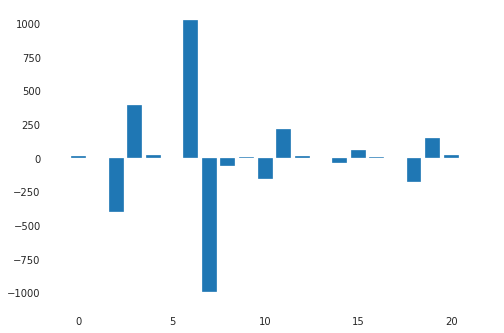

In [16]:
#Plot our coefficients for feature importance

plt.bar([x for x in range(len(importance))], importance)

plt.show()

### Permutation Importance

In [17]:
#Create our permuter to show our permutation importance
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)

In [18]:
#Fit our data to the permuter
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('selectkbest',
                                                 SelectKBest(k='all',
                                                             score_func=<function f_classif at 0x7fab78e7ef28>)),
                                                ('linearregression',
                                                 LinearRegression(copy_X=True,
                                                                  fit_intercept=True,
                                                                  n_jobs=None,
                                               

In [19]:
#Plot our permutation importances
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_train.columns.tolist()
)

#Random Forest Model -rfmodel-

In [20]:
#Create our pipeline
rfmodel = make_pipeline(
    RandomForestRegressor()
)

In [21]:
#Fit our data to our model

rfmodel.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [22]:
# Get our fitted model scores
#Check our accuracy on our different sets
print('Training Accuracy: ', rfmodel.score(X_train, y_train))
print('Validation Accuracy: ', rfmodel.score(X_val, y_val))
print('Testing Accuracy: ', rfmodel.score(X_test, y_test))

Training Accuracy:  0.9953813576649724
Validation Accuracy:  0.9707886066482027
Testing Accuracy:  0.9711475389378543


In [23]:
#Determine our MAE to compare to our baseline
mae = mean_absolute_error(y_test, rfmodel.predict(X_test))
mse = mean_squared_error(y_test, rfmodel.predict(X_test))
r2 = r2_score(y_test, rfmodel.predict(X_test))
print(mae)
print(mse)
print(r2)

7.620581723027375
211.50001543880833
0.9711475389378543


In [24]:
#Determine our MAE to compare to our baseline
mae = mean_absolute_error(y_test, model.predict(X_test))
mse = mean_squared_error(y_test, model.predict(X_test))
r2 = r2_score(y_test, model.predict(X_test))
print(mae)
print(mse)
print(r2)

15.783871469373393
479.2153956854419
0.9346262764297752


### -rfmodel- Feature Importance

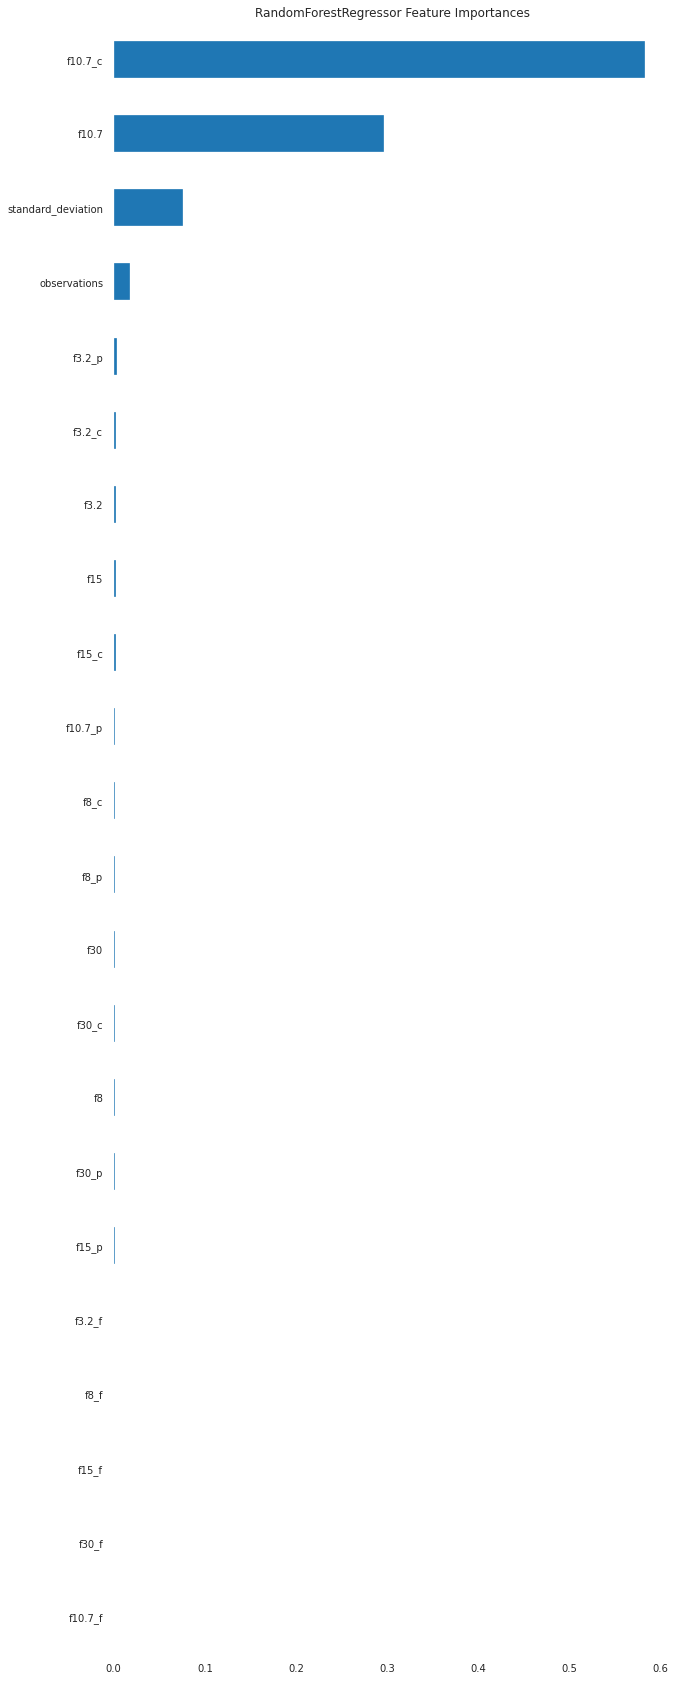

In [25]:
encoder = rfmodel.named_steps['randomforestregressor']
encoded_columns = X_val.columns
importances = pd.Series(encoder.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 30))
plt.title('RandomForestRegressor Feature Importances')
importances.sort_values().plot.barh()

### Perumtation Importance with rfmodel

In [26]:
#Create our permuter to show our permutation importance
permuter = PermutationImportance(
    rfmodel,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)

In [27]:
#Fit our data to the permuter
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('randomforestregressor',
                                                 RandomForestRegressor(bootstrap=True,
                                                                       ccp_alpha=0.0,
                                                                       criterion='mse',
                                                                       max_depth=None,
                                                                       max_features='auto',
                                                                       max_leaf_nodes=None,
                                                                       max_samples=None,
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_split=None,
                      

In [28]:
#Plot our permutation importances
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_train.columns.tolist()
)

### -rfmodel- Partial Dependence Plots

In [29]:
#Pick our feature to evaluate
feature = 'f10.7_c'

isolated = pdp_isolate(
    model=rfmodel,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fab1f5d05f8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fab20988cc0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


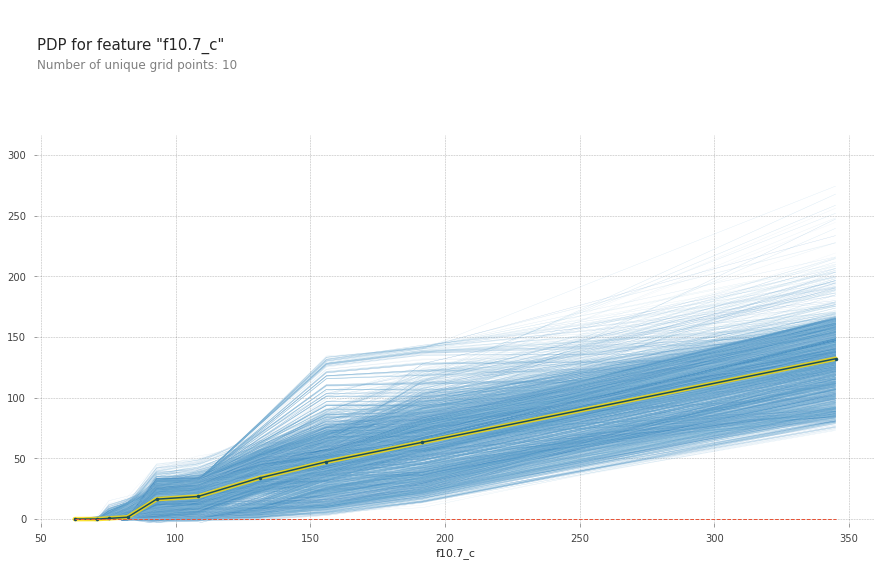

In [30]:
pdp_plot(isolated, feature_name=feature, plot_lines=True)

# Visuals for our article

In [31]:
px.scatter(df, x='date', y='number_of_sunspots', color='f30_c')

In [32]:
px.scatter(df, x='date', y='number_of_sunspots', color='f15')

In [33]:
fig = px.scatter(df, x='date', y='number_of_sunspots', color='f10.7',
                 labels={
                     'number_of_sunspots': 'Number of Sunspots',
                     'date': 'Year'
                 },
                 title='Sunspot Cycle colored by f10.7')
fig.show()

In [34]:
fig = px.scatter(df, x='f30', y='f15', color='number_of_sunspots',
                 labels={
                     'number_of_sunspots': 'Number of Sunspots',
                 },
                 title='f15 Over f30 Colored by Number of Sunspots')
fig.show()


#px.scatter(df, x='f30', y='f15', color='number_of_sunspots')

In [35]:
px.scatter(df, x='f10.7', y='f15', color='number_of_sunspots')

In [36]:
fig = px.scatter(df, x='date', y='number_of_sunspots',
                 labels={
                     'number_of_sunspots': 'Number of Sunspots',
                     'date': 'Year'
                 },
                 title='Sunspot Cycle')
fig.show()

#px.scatter(sspot, x='date', y='number_of_sunspots')